In [1]:
%matplotlib inline
import pandas as pd
import requests
import numpy as np
from pandas.io.json import json_normalize
import datetime

In [2]:
##Dict of session:uri
FMlinkList = {'August':'https://www.commonsense.org/education/privacy/blog/digital-redlining-access-privacy',
        'September':'http://dmlcentral.net/speculative-design-for-emergent-learning-taking-risks/',
        'October':'http://marginalsyllab.us/wp-content/uploads/2016/08/PWFlow-Intro.pdf',
        'November':'https://helenbeetham.com/2016/11/14/ed-tech-and-the-circus-of-unreason/',
        'January':'http://marginalsyllab.us/the-school-and-social-progress-by-john-dewey/',
        'February':'http://marginalsyllab.us/preface-to-research-writing-rewired-lessons-that-ground-students-digital-learning-by-dawn-reed-and-troy-hicks/'}

In [4]:
##Create empty dataFrame, and append data scraped from annotation api
dfAllupdate = pd.DataFrame(columns=['created','document.title','group','id','links.html',
       'links.incontext','links.json','permissions.admin',
       'permissions.delete','permissions.read','permissions.update',
       'references','tags','target','text','updated','uri','user','session'])
for session,link in FMlinkList.items():
    df = scrapeAPI(session,link)
    dfAllupdate = dfAllupdate.append(df)
print('Total Records: ',len(dfAllupdate))

November
https://helenbeetham.com/2016/11/14/ed-tech-and-the-circus-of-unreason/
Number of Records Found for this Session:  155
Scraped:
0
20
40
60
80
100
120
140
155
October
http://marginalsyllab.us/wp-content/uploads/2016/08/PWFlow-Intro.pdf
Number of Records Found for this Session:  166
Scraped:
0
20
40
60
80
100
120
140
160
166
September
http://dmlcentral.net/speculative-design-for-emergent-learning-taking-risks/
Number of Records Found for this Session:  87
Scraped:
0
20
40
60
80
87
August
https://www.commonsense.org/education/privacy/blog/digital-redlining-access-privacy
Number of Records Found for this Session:  190
Scraped:
0
20
40
60
80
100
120
140
160
180
190
January
http://marginalsyllab.us/the-school-and-social-progress-by-john-dewey/
Number of Records Found for this Session:  242
Scraped:
0
20
40
60
80
100
120
140
160
180
200
220
240
242
February
http://marginalsyllab.us/preface-to-research-writing-rewired-lessons-that-ground-students-digital-learning-by-dawn-reed-and-troy

In [36]:
dateNow = datetime.datetime.now().strftime('%m%d%y_%H%M')
print(dateNow)
!mkdir $dateNow
for session in FMlinkList:
    Table1 = pd.DataFrame(index=list(dfAllupdate[dfAllupdate['session'] == session
                                            ].drop_duplicates('user')['user']))
    Table1['annotations'] = dfAllupdate[(dfAllupdate['session'] == session)&
                                (dfAllupdate['references'].isnull())
                               ].groupby('user').size()
    Table1['replies'] = dfAllupdate[(dfAllupdate['session'] == session)&
                                (~dfAllupdate['references'].isnull())
                               ].groupby('user').size()
    Table1.fillna(0,inplace=True)
    Table1.index = Table1.index.str[5:].str[:-12]
    Table1['total'] = Table1['replies'] + Table1['annotations']
    Table1.name = 'Table1'
    Graph1 = Table1.T
    Graph1.name = 'Graph1'
    
    Graph3 = dfAllupdate[(dfAllupdate['session'] == 'August')
                                ].groupby([pd.TimeGrouper('15T'),'user']
                                         ).size().to_frame()
    Graph3.reset_index(level='user',inplace=True)
    Graph3 = pd.pivot_table(Graph3,columns='user',values=0,
                                         index=pd.Grouper(freq='15T'),fill_value=0)
    Graph3 = Graph3.rename(columns=lambda x: x[5:][:-12])
    Graph3.name = 'Graph3'

    graphEntireConversation = dfAllupdate[(dfAllupdate['session'] == session)
                                ].groupby([pd.TimeGrouper('D'),'user']).size().to_frame()
    graphEntireConversation.reset_index(level='user',inplace=True)
    graphEntireConversation['Total'] = graphEntireConversation.sum(axis=1)
    graphEntireConversation = pd.pivot_table(graphEntireConversation,columns='user',values=0,
                                         index=pd.Grouper(freq='D'),fill_value=0)
    graphEntireConversation = graphEntireConversation.rename(columns=lambda x: x[5:][:-12])
    graphEntireConversation['Total'] = graphEntireConversation.sum(axis=1)
    graphEntireConversation.name = 'graphEntireConversation'
    
    sessionDir = dateNow + '/' + session
    saveList = [Table1,Graph1,Graph3,graphEntireConversation]
    !mkdir $sessionDir
    print(sessionDir)
    for file in saveList:
        print(sessionDir + '/' + file.name + '.csv')
        print(sessionDir + '/' + file.name + '.pkl')
        file.to_csv(sessionDir + '/' + file.name + '.csv')
        file.to_pickle(sessionDir + '/' + file.name + '.pkl')

032217_2125
032217_2125/November
032217_2125/November/Table1.csv
032217_2125/November/Table1.pkl
032217_2125/November/Graph1.csv
032217_2125/November/Graph1.pkl
032217_2125/November/Graph3.csv
032217_2125/November/Graph3.pkl
032217_2125/November/graphEntireConversation.csv
032217_2125/November/graphEntireConversation.pkl
032217_2125/October
032217_2125/October/Table1.csv
032217_2125/October/Table1.pkl
032217_2125/October/Graph1.csv
032217_2125/October/Graph1.pkl
032217_2125/October/Graph3.csv
032217_2125/October/Graph3.pkl
032217_2125/October/graphEntireConversation.csv
032217_2125/October/graphEntireConversation.pkl
032217_2125/September
032217_2125/September/Table1.csv
032217_2125/September/Table1.pkl
032217_2125/September/Graph1.csv
032217_2125/September/Graph1.pkl
032217_2125/September/Graph3.csv
032217_2125/September/Graph3.pkl
032217_2125/September/graphEntireConversation.csv
032217_2125/September/graphEntireConversation.pkl
032217_2125/August
032217_2125/August/Table1.csv
032217

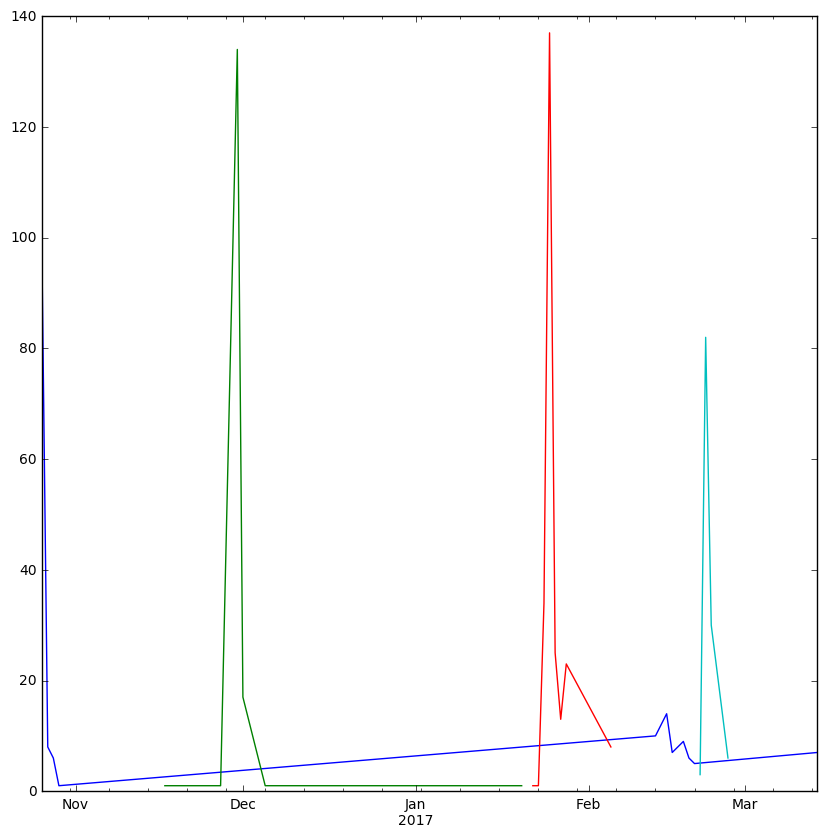

In [214]:
tmp4 = pd.read_pickle('032217_1353/February/graphEntireConversation.pkl')
tmp['Total'].plot(legend=False,figsize=(10,10))
tmp2['Total'].plot(legend=False,figsize=(10,10))
tmp3['Total'].plot(legend=False,figsize=(10,10))
tmp4['Total'].plot(legend=False,figsize=(10,10))

In [122]:
users.to_excel('data/users.xlsx',sheet_name='nodes',index=False)

In [3]:
def scrapeAPI(session,uri):
    n = 0
    payload = {'url':uri}
    r = requests.get('https://hypothes.is/api/search',params=payload)
    df = pd.DataFrame(columns=['created', 'document.title', 'group', 'id', 'links.html',
       'links.incontext', 'links.json', 'permissions.admin',
       'permissions.delete', 'permissions.read', 'permissions.update',
       'references', 'tags', 'target', 'text', 'updated', 'uri', 'user'])
    total = r.json()['total']
    print(session)
    print(uri)
    print('Number of Records Found for this Session: ',total)
    print('Scraped:')
    while n < total:
        print(n)
        df = df.append(json_normalize(r.json()['rows']))
        n = len(df)
        payload = {
            'url':uri,
            'offset':n}
        r = requests.get('https://hypothes.is/api/search',params=payload)
    print(n)
    df['session'] = session
    df['updated'] = pd.to_datetime(df['updated'])
    df['created'] = pd.to_datetime(df['created'])
    df = df.set_index(df['created'])
    df.index = df.index.tz_localize('UTC').tz_convert('US/Mountain')
    return df

In [21]:
#To find first and last in a session
print(dfAllupdate[dfAllupdate['session'] == 'September'].nsmallest(1,'created')[['id','user']])
print(dfAllupdate[dfAllupdate['session'] == 'September'].nlargest(1,'created')[['id','user']])
##For the created/updated bug in API
updatedAnnotationCounts = [(len(dfAllupdate[(dfAllupdate['session'] == 'August')]),
                          len(dfAllupdate[(dfAllupdate['session'] == 'August')&
      (dfAllupdate['updated'] - dfAllupdate['created']
       > pd.Timedelta(1,unit='s'))]))]
Graph2 = pd.DataFrame(data=updatedAnnotationCounts,columns=['annotations','updated'])
Graph2 = Graph2.T
Graph2.rename(columns={0:'August'},inplace=True)
Graph2.plot.pie(y='August')
Graph2.to_csv('data/Graph2.csv')
Graph2.to_pickle('data/Graph2.pkl')